# Testing of the wedge

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quadrature
import tensorflow as tf

2022-08-23 12:16:32.058995: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def read_cbin(filename, bits=32, order='C', dimensions=3, records=False):
        ''' Read a binary file with three inital integers (a cbin file).
        
        Parameters:
                * filename (string): the filename to read from
                * bits = 32 (integer): the number of bits in the file
                * order = 'C' (string): the ordering of the data. Can be 'C'
                        for C style ordering, or 'F' for fortran style.
                * dimensions (int): the number of dimensions of the data (default:3)
                * records (boolean): does the file contain record separators?
                        
        Returns:
                The data as a N dimensional numpy array.
        
        Example:
                > data = read_cbin(filename='nsrc_z6.981.dat')

        '''

        assert(bits ==32 or bits==64)

        f = open(filename)

        #print('Reading cbin file: %s' % filename)

        counter = dimensions+3 if records else dimensions
        header = np.fromfile(f, count=counter, dtype='int32')
        if records: temp_mesh=header[1:4]
        else: temp_mesh=header[0:3]

        datatype = np.float32 if bits == 32 else np.float64
        data = np.fromfile(f, dtype=datatype, count=np.prod(temp_mesh))
        data = data.reshape(temp_mesh, order=order)
        f.close()
        return data

def save_cbin(filename, data, bits=32, order='C'):
        ''' Save a binary file with three inital integers (a cbin file).
        
        Parameters:
                * filename (string): the filename to save to
                * data (numpy array): the data to save
                * bits = 32 (integer): the number of bits in the file
                * order = 'C' (string): the ordering of the data. Can be 'C'
                        for C style ordering, or 'F' for fortran style.
                        
        Returns:
                Nothing
        '''
        #print('Saving cbin file: %s' % filename)
        assert(bits ==32 or bits==64)
        f = open(filename, 'wb')
        mesh = np.array(data.shape).astype('int32')
        mesh.tofile(f)
        datatype = (np.float32 if bits==32 else np.float64)
        data.flatten(order=order).astype(datatype).tofile(f)
        f.close()

In [3]:
def wedge_removal_original(
    OMm,
    redshifts,
    HII_DIM,
    cell_size,
    Box_uv,
    chunk_length=501,
    blackman=True,
):
    """Computing horizon wedge removal. Implements "sliding" procedure
    of removing the wedge for every redshift separately.
    Args:
        OMm: Omega matter
        redshifts: list of redshifts in a lightcone
        HII_DIM: size of the HII simulation box (see `21cmFASTv3`)
        cell_size: size of a cell in Mpc
        Box_uv: box in UV space on which wedge removal is to be computed
        chunk_length: length of a sliding chunk (in number of z-slices)
        blackman: either to use Blackman-Harris taper or not
    Returns:
        Box_final: wedge-removed box in real space
    """
    
    if chunk_length % 2 == 0:
        chunk_length += 1
        
    def one_over_E(z, OMm):
        return 1 / np.sqrt(OMm * (1.0 + z) ** 3 + (1 - OMm))

    def multiplicative_factor(z, OMm):
        return (
            1
            / one_over_E(z, OMm)
            / (1 + z)
            * quadrature(lambda x: one_over_E(x, OMm), 0, z)[0]
        )

    MF = np.array([multiplicative_factor(z, OMm) for z in redshifts]).astype(
        np.float32
    )
    redshifts = redshifts.astype(np.float32)

    k = np.fft.fftfreq(HII_DIM, d=cell_size)
    k_parallel = np.fft.fftfreq(chunk_length, d=cell_size)
    delta_k = k_parallel[1] - k_parallel[0]
    k_cube = np.meshgrid(k, k, k_parallel)

    bm = np.abs(np.fft.fft(np.blackman(chunk_length))) ** 2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= 1e-10)[0][0] - 1)
    BM = np.blackman(chunk_length)[np.newaxis, np.newaxis, :]

    box_shape = Box_uv.shape
    Box_final = np.empty(box_shape, dtype=np.float32)
    empty_box = np.zeros(k_cube[0].shape)
    Box_uv = np.concatenate((empty_box, Box_uv, empty_box), axis=2)

    for i in range(chunk_length, box_shape[-1] + chunk_length):
        print(i, end = " ")
        t_box = Box_uv[..., i - chunk_length // 2 : i + chunk_length // 2 + 1]
        W = k_cube[2] / (
            np.sqrt(k_cube[0] ** 2 + k_cube[1] ** 2)
            * MF[min(i - chunk_length // 2 - 1, box_shape[-1] - 1)]
            + buffer
        )
        w = np.logical_or(W < -1.0, W > 1.0)
        # w = cp.array(W[i + chunk_length - 1])
        if blackman == True:
            t_box = t_box * BM
        Box_final[..., i - chunk_length] = np.real(
            np.fft.ifftn(np.fft.fft(t_box, axis=-1) * w)
        )[
            ..., chunk_length // 2
        ]  # taking only middle slice in redshift

    print()
    return Box_final.astype(np.float32)

def wedge_removal_tools21cm(lightcone, redshifts, OMm, cell_size=None, chunk_length=None, buffer_threshold = 1e-10):
    """Rolling over the lightcone and removing the wedge for every frequency channel.
    Parameters:
        lightcone (array): The lightcone, of shape `(n_cells, n_cells, n_redshfts)`.
        redshifts (array): The redshifts of every frequency channel.
        cell_size (float): Resolution of the lightcone voxels.
            It is assumed that the lightcone is made of cubical voxels of volume `cell_size^3`.
        chunk_length (int): Length of the box in z-direction used for wedge removal.
            Defaults to `n_cells`.
        OMm (float): Omega matter.
        buffer_threshold (float): Threshold which defines a wedge buffer.
            Buffer is then calculated as k-value for which Blackman taper power is below threshold.
    Returns:
        Cleaned lightcone.
    """
    def one_over_E(z, OMm):
        return 1 / np.sqrt(OMm*(1.+z)**3 + (1 - OMm))
    def multiplicative_factor(z, OMm):
        return 1 / one_over_E(z, OMm) / (1+z) * quadrature(lambda x: one_over_E(x, OMm), 0, z)[0]

    if cell_size is None:
        cell_size = np.min(lightcone.shape)
    if chunk_length is None:
        chunk_length = np.min(lightcone.shape)
    if chunk_length % 2 == 0:
        chunk_length += 1

    Box_uv = np.fft.fft2(lightcone.astype(np.float32), axes=(0, 1))
    redshifts = redshifts.astype(np.float32)
    MF = np.array([multiplicative_factor(z, OMm) for z in redshifts], dtype = np.float32)

    k = np.fft.fftfreq(len(lightcone), d=cell_size)
    k_parallel = np.fft.fftfreq(chunk_length, d=cell_size)
    delta_k = k_parallel[1] - k_parallel[0]
    k_cube = np.meshgrid(k, k, k_parallel)
    k_perp, k_par = np.sqrt(k_cube[0]**2 + k_cube[1]**2).astype(np.float32), k_cube[2].astype(np.float32)

    bm = np.abs(np.fft.fft(np.blackman(chunk_length)))**2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= buffer_threshold)[0][0] - 1)
    buffer = buffer.astype(np.float32)
    BM = np.blackman(chunk_length).astype(np.float32)[np.newaxis, np.newaxis, :]

    box_shape = Box_uv.shape
    Box_final = np.empty(box_shape, dtype = np.float32)
    empty_box = np.zeros(k_cube[0].shape, dtype = np.float32)
    Box_uv = np.concatenate((empty_box, Box_uv, empty_box), axis = 2)

    for i in range(chunk_length, box_shape[-1] + chunk_length):
        t_box = np.copy(Box_uv[..., i-chunk_length//2: i+chunk_length//2 + 1])
        # t_box = np.copy(Box_uv[..., i-chunk_length//2: i+chunk_length//2])

        t_box *= BM
        W = k_par / (k_perp * MF[min(i - chunk_length // 2 - 1, box_shape[-1] - 1)] + buffer)
        w = np.logical_or(W < -1., W > 1.)
        Box_final[..., i - chunk_length] = np.real(np.fft.ifftn(np.fft.fft(t_box, axis = -1) * w))[..., chunk_length // 2]

    return Box_final.astype(np.float32)

In [4]:
data = read_cbin("/store/ska/sk09/segunet/test/dT3_21cm_i0.bin")
data_clean = read_cbin("/store/ska/sk09/segunet/test/dT_21cm_i0.bin")
data_wedge = read_cbin("/store/ska/sk09/segunet/test/dT3wdg_21cm_i0.bin")
data.shape, data_clean.shape, data_wedge.shape

((128, 128, 552), (128, 128, 552), (128, 128, 552))

In [5]:
redshifts = np.loadtxt("/store/ska/sk09/segunet/test/lc_redshifts.txt", dtype = float)
redshifts.shape, redshifts[0], redshifts[-1]

((552,), 7.0, 11.018195)

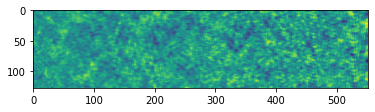

In [6]:
plt.imshow(data[0])

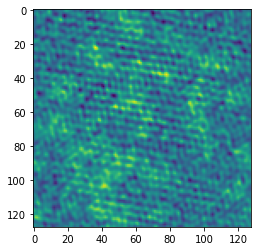

In [7]:
plt.imshow(data[..., 0])

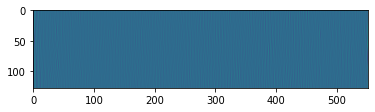

In [8]:
plt.imshow(data_wedge[0])

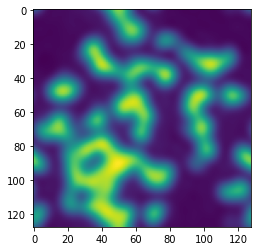

In [9]:
plt.imshow(data_wedge[..., 0])

In [10]:
data_W_original = wedge_removal_original(
    0.27,
    redshifts,
    128,
    2.0,
    np.fft.fft2(data, axes=(0, 1)),
    chunk_length=128,
    blackman=True,
)

129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 

In [11]:
data_W_tools21cm = wedge_removal_tools21cm(
    data,
    redshifts,
    0.27,
)

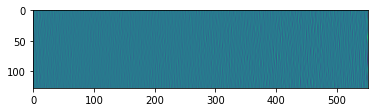

In [12]:
plt.imshow(data_W_original[0])

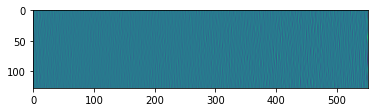

In [13]:
plt.imshow(data_W_tools21cm[0])

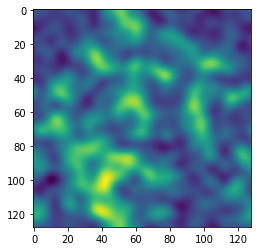

In [14]:
plt.imshow(data_W_original[..., 0])

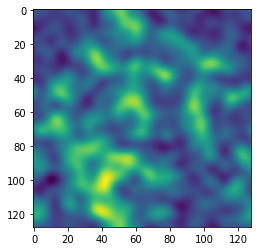

In [15]:
plt.imshow(data_W_tools21cm[..., 0])

# Tensorflow version
The difference between previous versions is that I allowed for all of the constant calculations to be computed in advance and saved on the GPU, and then one can iterate over the whole dataset

In [16]:
def one_over_E(z, OMm):
    return 1 / np.sqrt(OMm * (1.0 + z) ** 3 + (1 - OMm))

def multiplicative_factor(z, OMm):
    return (
        1
        / one_over_E(z, OMm)
        / (1 + z)
        * quadrature(lambda x: one_over_E(x, OMm), 0, z)[0]
    )
def calculate_k_cube(HII_DIM, chunk_length, cell_size):
    k = np.fft.fftfreq(HII_DIM, d=cell_size)
    k_parallel = np.fft.fftfreq(chunk_length, d=cell_size)
    delta_k = k_parallel[1] - k_parallel[0]
    k_cube = np.meshgrid(k, k, k_parallel)
    return tf.constant(k_cube, dtype = tf.float32), tf.constant(delta_k, dtype = tf.float32)

def calculate_blackman(chunk_length, delta_k):
    bm = np.abs(np.fft.fft(np.blackman(chunk_length))) ** 2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= 1e-10)[0][0] - 1)
    BM = np.blackman(chunk_length)[np.newaxis, np.newaxis, :]
    return tf.constant(BM, dtype = tf.complex64), tf.constant(buffer, dtype = tf.float32)

def wedge_removal_tf(
    OMm,
    redshifts,
    HII_DIM,
    cell_size,
    Box,
    chunk_length=501,
    blackman=True,
    MF = None,
    k_cube_data = None,
    blackman_data = None,
    
):
    # here we allow to pass multiplicative factor, k_cube_data, blackman_data, just so that it is not constantly re-computed
    
    permute = [2, 0, 1]
    inverse_permute = [1, 2, 0]
    
    if chunk_length % 2 == 0:
        chunk_length += 1
    
    if MF is None:
        MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
    # Box = tf.constant(Box, dtype = tf.float32)
    Box_uv = tf.transpose(tf.cast(Box, tf.complex64), perm = permute)
    Box_uv = tf.signal.fft2d(Box_uv)
    Box_uv = tf.transpose(Box_uv, perm = inverse_permute)

    if k_cube_data is None:
        k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
    else:
        k_cube, delta_k = k_cube_data

    if blackman_data is None:
        BM, buffer = calculate_blackman(chunk_length, delta_k) 
    else:
        BM, buffer = blackman_data

    box_shape = Box_uv.shape
    # Box_final = np.empty(box_shape, dtype=np.float32)
    Box_final = []
    empty_box = tf.zeros(k_cube[0].shape, dtype = tf.complex64)
    Box_uv = tf.concat([empty_box, Box_uv, empty_box], axis=2)

    for i in range(chunk_length, box_shape[-1] + chunk_length):
        t_box = Box_uv[..., i - chunk_length // 2 : i + chunk_length // 2 + 1]
        W = k_cube[2] / (
            tf.math.sqrt(k_cube[0] ** 2 + k_cube[1] ** 2)
            * MF[tf.math.minimum(i - chunk_length // 2 - 1, box_shape[-1] - 1)]
            + buffer
        )
        w = tf.cast(tf.math.logical_or(W < -1.0, W > 1.0), tf.complex64)
        # w = cp.array(W[i + chunk_length - 1])
        if blackman is True:
            t_box = t_box * BM
        Box_final.append(
            tf.math.real(tf.signal.ifft3d(tf.signal.fft(t_box) * w)[..., chunk_length // 2])
        )

    return tf.transpose(tf.convert_to_tensor(Box_final), perm = inverse_permute).numpy()


In [17]:
OMm = 0.27
HII_DIM = 128
chunk_length = 129
cell_size = 2.0

In [18]:
MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
BM, buffer = calculate_blackman(chunk_length, delta_k)

2022-08-23 12:21:36.032185: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 12:21:36.033574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-23 12:21:36.076282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-08-23 12:21:36.076318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-23 12:21:36.080152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-23 12:21:36.080199: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11

Once this is pre-computed, we have everything ready to be applied on the full dataset.
The way we would proceed for the whole dataset would be something like this:
```
dataset = []
for f in filenames:
    dataset.append(load_data(f))

dataset_W = []
for data in dataset:
    Box = tf.constant(data, dtype = tf.float32)
    data_W_tf = wedge_removal_tf(
        OMm,
        redshifts,
        HII_DIM,
        cell_size,
        Box,
        chunk_length,
        blackman = True,
        MF = MF,
        k_cube_data = (k_cube, delta_k),
        blackman_data = (BM, buffer)
    )
    dataset_W.append(data_W_tf)
```

In [19]:
Box = tf.constant(data, dtype = tf.float32)

In [20]:
data_W_tf = wedge_removal_tf(
    OMm,
    redshifts,
    HII_DIM,
    cell_size,
    Box,
    chunk_length,
    blackman = True,
    MF = MF,
    k_cube_data = (k_cube, delta_k),
    blackman_data = (BM, buffer)
)

2022-08-23 12:21:37.188826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-08-23 12:21:37.365127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-23 12:21:37.588907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


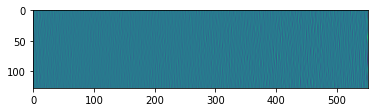

In [21]:
plt.imshow(data_W_tf[0])

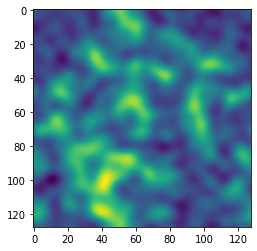

In [22]:
plt.imshow(data_W_tf[..., 0])

In [23]:
(
    np.sum(np.abs(data_W_tf - data_W_tools21cm)), 
    np.sum(np.abs(data_W_tf - data_W_original)), 
    np.sum(np.abs(data_W_original - data_W_tools21cm))
)

(1.6283878, 1.7251879, 0.51188475)

For the whole lightcone, the sum of 1 difference is absolutely negligible, only due to numerics... One can see that there's 0.5 difference between two numpy runs. The difference is a bit bigger towards tensorflow implementation probably because in `numpy` one uses `float64/complex128`, and in `tensorflow` `float32/complex64`.